In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import jax.numpy as jnp
import jax
import jax.random as jr
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
import wat
from eins import EinsOp
import treescope


is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

In [15]:
%cd ~/cdv/

/home/nmiklaucic/cdv


/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


gamma
(9.568116731031246, -0.021411738147320863, 0.34823974495667276)
-1.457


<Axes: ylabel='Density'>

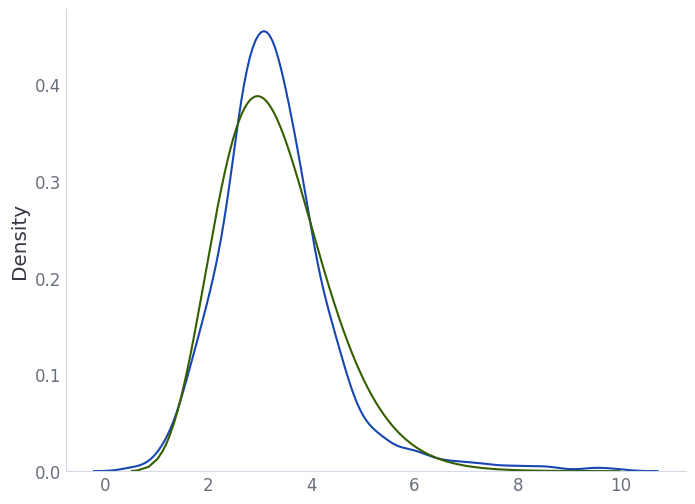

In [100]:
import json

with open('precomputed/mptrj/metadata.json') as f:
    metadata = json.load(f)

centers = np.array(metadata['distances']['bins'])
total_counts = np.array(metadata['distances']['counts'])

bin_diameter = centers[1] - centers[0]
bin_rad = bin_diameter / 2

counts = np.rint(total_counts / sum(total_counts) * 2048).astype(int)
samples = []

rng = np.random.default_rng(29205)
for center, count in zip(centers, counts):
    samples.extend(rng.uniform(center - bin_rad, center + bin_rad, (count,)))

samples = jnp.array(samples)
samples

import scipy.stats.distributions as scipy_dist

dist_fits = {}
for dist_name in 'gamma'.split(' '):
    dist = getattr(scipy_dist, dist_name)
    fit = dist.fit(samples)
    dist_fit = dist(*fit)
    dist_fits[dist_name] = (dist_fit)
    print(dist_name)
    print(fit)
    print(round(dist_fit.logpdf(samples).mean(), 3))


sns.kdeplot(samples)
sns.lineplot(x=samples, y=dist_fits[dist_name].pdf(samples))

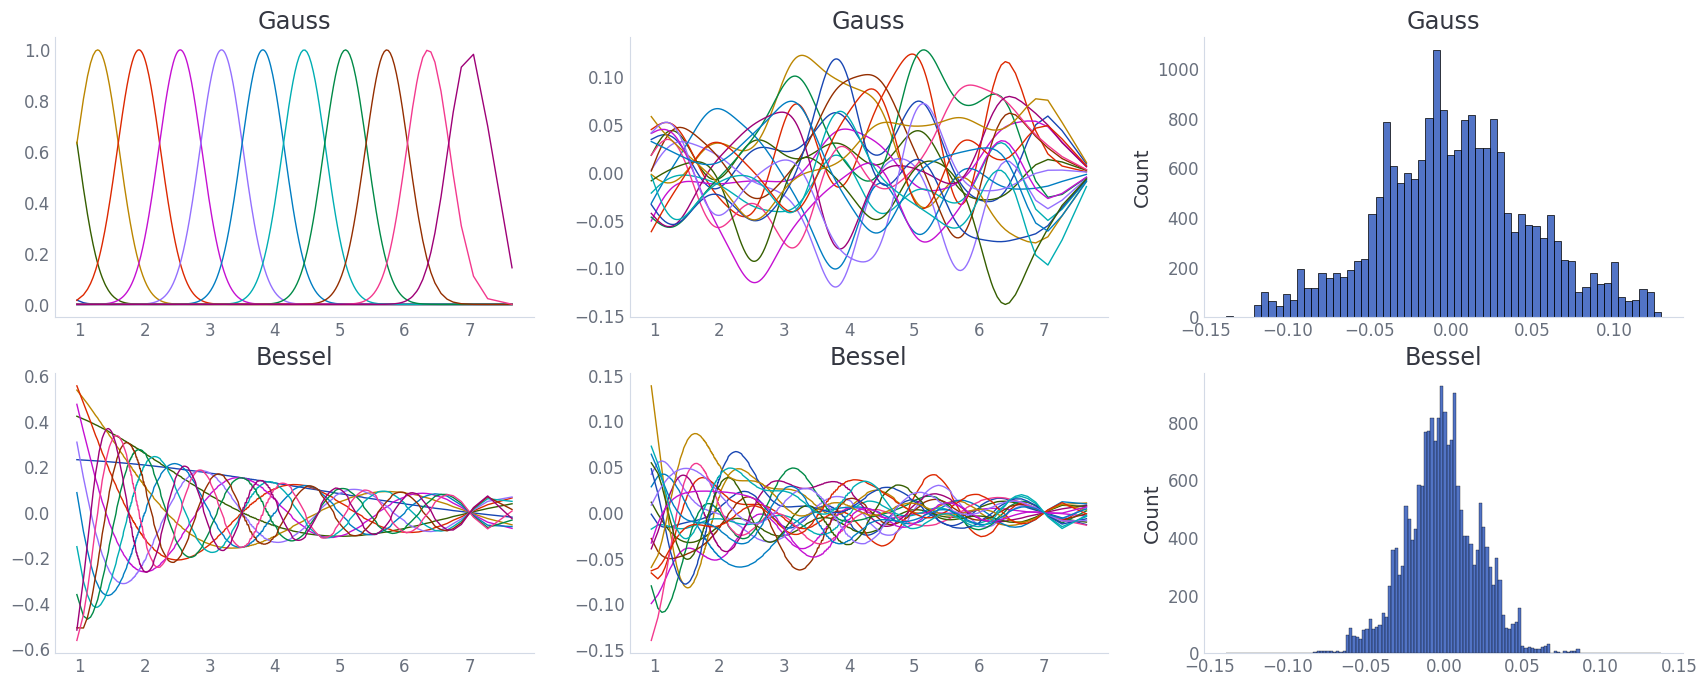

In [118]:
from cdv.mace.edge_embedding import GaussBasis, BesselBasis, RadialBasis
from cdv.layers import Context
from numpyro import distributions as dist

r_dist = dist.Gamma(dist_fits['gamma'].args[0], 1 / dist_fits['gamma'].args[-1])

ctx = Context(training=False)

rmax = 7
qq = jnp.linspace(0, 1, 1002)[1:-1]
rr = r_dist.icdf(qq).astype(jnp.bfloat16)

num_basis = 12

bases = {
    'Gauss': GaussBasis(num_basis=num_basis, mu_max=rmax, sd=4/12),
    'Bessel': BesselBasis(num_basis=num_basis, freq_trainable=False)
}

coefs = np.random.randn(num_basis, 20)
coefs = coefs / coefs.shape[-1]

fig, axs = plt.subplots(len(bases), 3, figsize=(3 * 7, len(bases) * 4), squeeze=False)

for (name, base), row in zip(bases.items(), axs):
    ax1, ax2, ax3 = row
    for ax in row:
        ax.set_title(name)

    out, params = base.init_with_output(jr.key(234), rr, r_max=rmax, ctx=ctx)
    ax1.plot(rr, out, lw=1)
    ax2.plot(rr, out @ coefs, lw=1)    
    sns.histplot((out @ coefs).reshape(-1), ax=ax3)

In [12]:
dist.Gamma?

Init signature: dist.Gamma(concentration, rate=1.0, *, validate_args=None)
Docstring:     
Base class for probability distributions in NumPyro. The design largely
follows from :mod:`torch.distributions`.

:param batch_shape: The batch shape for the distribution. This designates
    independent (possibly non-identical) dimensions of a sample from the
    distribution. This is fixed for a distribution instance and is inferred
    from the shape of the distribution parameters.
:param event_shape: The event shape for the distribution. This designates
    the dependent dimensions of a sample from the distribution. These are
    collapsed when we evaluate the log probability density of a batch of
    samples using `.log_prob`.
:param validate_args: Whether to enable validation of distribution
    parameters and arguments to `.log_prob` method.

As an example:

.. doctest::

   >>> import jax.numpy as jnp
   >>> import numpyro.distributions as dist
   >>> d = dist.Dirichlet(jnp.ones((2, 3, 4)